In [23]:
# Setup path to import src
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from src.utils.cds_plotter import CDSPlotter

In [24]:
from src.utils import config
# Example usage with new paths:
# plotter = CDSPlotter()
# plotter.load_data('GARCH', config.OUTPUT_DIR / 'cds_spreads_garch_mc.csv')

# CDS Spread Visualization

This notebook demonstrates how to use the `CDSPlotter` class to visualize CDS spreads from different models.

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import importlib
from src.utils import cds_plotter

# Force reload to pick up changes
importlib.reload(cds_plotter)
from src.utils.cds_plotter import CDSPlotter

In [27]:
# Initialize the plotter
plotter = CDSPlotter()

# Load the data using config paths
from src.utils import config

# Check if files exist before loading
garch_file = config.OUTPUT_DIR / 'cds_spreads_garch_mc_all_firms.csv'
rs_file = config.OUTPUT_DIR / 'cds_spreads_regime_switching_mc_all_firms.csv'
ms_garch_file = config.OUTPUT_DIR / 'cds_spreads_ms_garch_mc_all_firms.csv'
merton_file = config.OUTPUT_DIR / 'cds_spreads_merton.csv'

if garch_file.exists():
    plotter.load_data('GARCH', garch_file)
else:
    print(f"Warning: {garch_file} not found.")

if rs_file.exists():
    plotter.load_data('Regime Switching', rs_file)
else:
    print(f"Warning: {rs_file} not found.")
    
if ms_garch_file.exists():
    plotter.load_data('MS-GARCH', ms_garch_file)
else:
    print(f"Warning: {ms_garch_file} not found.")

if merton_file.exists():
    plotter.load_data('Merton', merton_file)
else:
    print(f"Warning: {merton_file} not found.")

Loading data for Merton from C:\Users\Chase\Downloads\Seminar QF\Seminar QF\data\output\cds_spreads_merton.csv...
  Mapped columns: ['spread_1y_bps', 'spread_3y_bps', 'spread_5y_bps']
  Successfully loaded 114776 rows for Merton.


## 1. GARCH Model Results
Visualizing the term structure of CDS spreads over time for the GARCH model.

In [28]:
# Plot for firm 14447 
plotter.plot_spreads_over_time('MS-GARCH', gvkey=220833, maturities=[1, 3, 5])

Error: Model 'MS-GARCH' not loaded.


## 2. Regime Switching Model Results
Visualizing the term structure of CDS spreads over time for the Regime Switching model.

In [29]:
plotter.plot_spreads_over_time('MS-GARCH', gvkey=220833, maturities=[1, 3, 5])

Error: Model 'MS-GARCH' not loaded.


## 3. Model Comparison
Comparing the 5-year CDS spread estimates between models.

In [30]:
plotter.plot_model_comparison(gvkey=220833, maturity=5, models=['GARCH', 'Regime Switching', 'MS-GARCH'])

No data found for firm 220833 and maturity 5y


## 4. Average Spreads Across All Firms
Visualizing the average CDS spreads for all firms in the dataset (GARCH model).

In [31]:
plotter.plot_average_spreads_over_time('Regime Switching', maturities=[1, 3, 5])

Error: Model 'Regime Switching' not loaded.


## 5. Merton Model Results
Visualizing the average CDS spreads for all firms using the analytical Merton model.

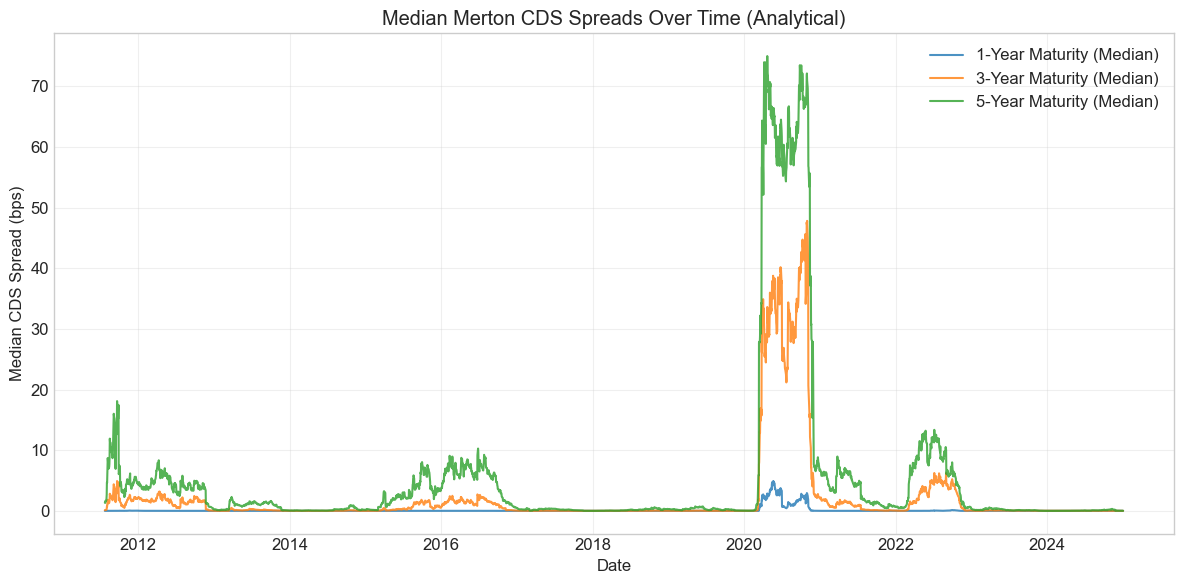

In [32]:
# Plot median spreads for 1, 3, and 5 years for Merton model
plotter.plot_average_spreads_over_time(
    'Merton', 
    maturities=[1, 3, 5], 
    title="Median Merton CDS Spreads Over Time (Analytical)", 
    aggregation='median'
)